<a href="https://colab.research.google.com/github/Allen123321/DEMO-DL/blob/master/30_days_deep_learning_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

4.时间序列数据建模流程范例

利用TensorFlow2.0建立时间序列RNN模型，对国内的新冠肺炎疫情结束时间进行预测。

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras import models,layers,losses,metrics,callbacks 

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.]),
 <a list of 7 Text major ticklabel objects>)

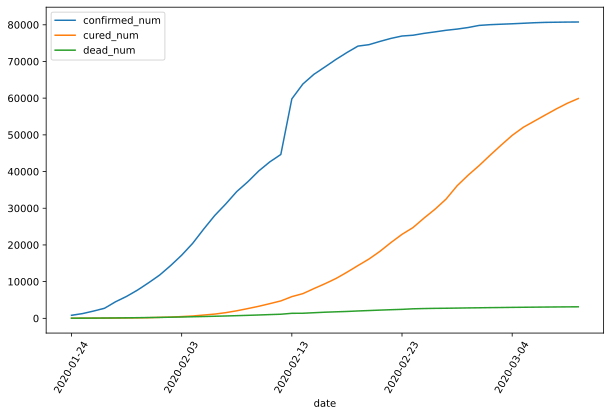

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
df = pd.read_csv("/content/covid-19.csv",sep = "\t")
df.plot(x = "date",y = ["confirmed_num","cured_num","dead_num"],figsize=(10,6))
plt.xticks(rotation=60)  # x轴下标旋转60度

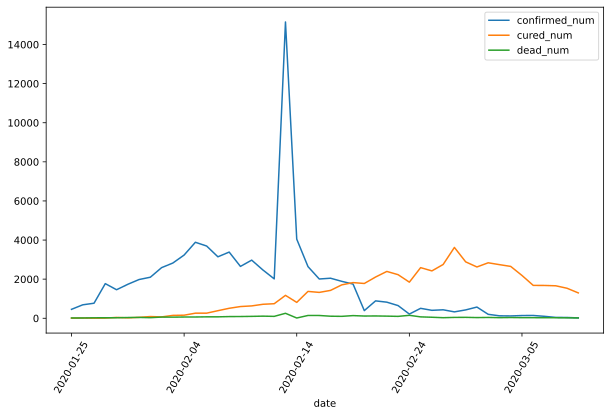

In [3]:
dfdata = df.set_index("date")  #设置时间列为索引 DataFrame.set_index(keys, drop=True, append=False, inplace=False, verify_integrity=False) 
dfdiff = dfdata.diff(periods=1).dropna() #计算数据与前一行的差异
dfdiff = dfdiff.reset_index("date") #重新设置索引
dfdiff.plot(x = "date",y = ["confirmed_num","cured_num","dead_num"],figsize=(10,6))
plt.xticks(rotation=60)
dfdiff = dfdiff.drop("date",axis = 1).astype("float32")

In [5]:
#用某日前8天窗口数据作为输入预测该日数据
WINDOW_SIZE = 8

def batch_dataset(dataset):
    dataset_batched = dataset.batch(WINDOW_SIZE,drop_remainder=True)
    return dataset_batched

ds_data = tf.data.Dataset.from_tensor_slices(tf.constant(dfdiff.values,dtype = tf.float32)) \
   .window(WINDOW_SIZE,shift=1).flat_map(batch_dataset)

ds_label = tf.data.Dataset.from_tensor_slices(
    tf.constant(dfdiff.values[WINDOW_SIZE:],dtype = tf.float32))

#数据较小，可以将全部训练数据放入到一个batch中，提升性能
ds_train = tf.data.Dataset.zip((ds_data,ds_label)).batch(38).cache()


In [6]:
# 定义模型
# 使用Keras接口有以下3种方式构建模型：使用Sequential按层顺序构建模型，使用函数式API构建任意结构模型，继承Model基类构建自定义模型。

# 此处选择使用函数式API构建任意结构模型。
#考虑到新增确诊，新增治愈，新增死亡人数数据不可能小于0，设计如下结构
class Block(layers.Layer):
    def __init__(self, **kwargs):
        super(Block, self).__init__(**kwargs)
    
    def call(self, x_input,x):
        x_out = tf.maximum((1+x)*x_input[:,-1,:],0.0)
        return x_out
    
    def get_config(self):  
        config = super(Block, self).get_config()
        return config

In [7]:
tf.keras.backend.clear_session()
x_input = layers.Input(shape = (None,3),dtype = tf.float32)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x_input)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x)
x = layers.LSTM(3,input_shape=(None,3))(x)
x = layers.Dense(3)(x)

#考虑到新增确诊，新增治愈，新增死亡人数数据不可能小于0，设计如下结构
#x = tf.maximum((1+x)*x_input[:,-1,:],0.0)
x = Block()(x_input,x)
model = models.Model(inputs = [x_input],outputs = [x])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, None, 3)      84          input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, None, 3)      84          lstm[0][0]                       
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, None, 3)      84          lstm_1[0][0]                     
_______________________________________________________________________________________

In [9]:
# 训练模型
# 训练模型通常有3种方法，内置fit方法，内置train_on_batch方法，以及自定义训练循环。此处我们选择最常用也最简单的内置fit方法。
# 循环神经网络调试较为困难，需要设置多个不同的学习率多次尝试，以取得较好的效果。
#自定义损失函数，考虑平方差和预测目标的比值
class MSPE(losses.Loss):
    def call(self,y_true,y_pred):
        err_percent = (y_true - y_pred)**2/(tf.maximum(y_true**2,1e-7))
        mean_err_percent = tf.reduce_mean(err_percent)
        return mean_err_percent
    
    def get_config(self):
        config = super(MSPE, self).get_config()
        return config

In [10]:
import os
import datetime

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer,loss=MSPE(name = "MSPE"))

stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join('data', 'autograph', stamp)

## 在 Python3 下建议使用 pathlib 修正各操作系统的路径
# from pathlib import Path
# stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# logdir = str(Path('./data/autograph/' + stamp))

tb_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
#如果loss在100个epoch后没有提升，学习率减半。
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",factor = 0.5, patience = 100)
#当loss在200个epoch后没有提升，则提前终止训练。
stop_callback = tf.keras.callbacks.EarlyStopping(monitor = "loss", patience= 200)
callbacks_list = [tb_callback,lr_callback,stop_callback]

history = model.fit(ds_train,epochs=500,callbacks = callbacks_list)

Epoch 1/500
1/1 [==============================] - 0s 70ms/step - loss: 3.2014
Epoch 2/500
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1/1 [==============================] - 0s 11ms/step - loss: 3.0037
Epoch 3/500
1/1 [==============================] - 0s 10ms/step - loss: 2.7871
Epoch 4/500
1/1 [==============================] - 0s 11ms/step - loss: 2.5547
Epoch 5/500
1/1 [==============================] - 0s 12ms/step - loss: 2.3126
Epoch 6/500
1/1 [==============================] - 0s 10ms/step - loss: 2.0699
Epoch 7/500
1/1 [==============================] - 0s 11ms/step - loss: 1.8383
Epoch 8/500
1/1 [==============================] - 0s 10ms/step - loss: 1.6297
Epoch 9/500
1/1 [==============================] - 0s 11ms/step - loss: 1.4553
Epoch 10/500
1/1 [==============================] - 0s 11ms/step - loss: 1.3213
Epoch 11/500
1/1 [==============================] - 0s 11ms/step - loss: 1.2248
Epoch 12/500
1/1 [==============================] - 0s 11

In [11]:
# 评估模型
# 评估模型一般要设置验证集或者测试集，由于此例数据较少，我们仅仅可视化损失函数在训练集上的迭代情况。
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.title('Training '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric])
    plt.show()

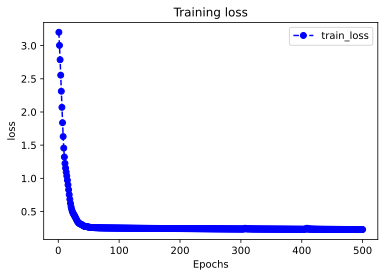

In [12]:
plot_metric(history,"loss")

In [13]:
# 五，使用模型
# 此处我们使用模型预测疫情结束时间，即 新增确诊病例为0 的时间。

#使用dfresult记录现有数据以及此后预测的疫情数据
dfresult = dfdiff[["confirmed_num","cured_num","dead_num"]].copy()
dfresult.tail()

,confirmed_num,cured_num,dead_num
41,143.0,1681.0,30.0
42,99.0,1678.0,28.0
43,44.0,1661.0,27.0
44,40.0,1535.0,22.0
45,19.0,1297.0,17.0


In [14]:
#预测此后100天的新增走势,将其结果添加到dfresult中
for i in range(100):
    arr_predict = model.predict(tf.constant(tf.expand_dims(dfresult.values[-38:,:],axis = 0)))

    dfpredict = pd.DataFrame(tf.cast(tf.floor(arr_predict),tf.float32).numpy(),
                columns = dfresult.columns)
    dfresult = dfresult.append(dfpredict,ignore_index=True)

In [15]:
dfresult.query("confirmed_num==0").head()

# 第55天开始新增确诊降为0，第45天对应3月10日，也就是10天后，即预计3月20日新增确诊降为0
# 注：该预测偏乐观

,confirmed_num,cured_num,dead_num
50,0.0,1019.0,3.0
51,0.0,968.0,2.0
52,0.0,919.0,1.0
53,0.0,873.0,0.0
54,0.0,829.0,0.0


In [16]:
dfresult.query("cured_num==0").head()

,confirmed_num,cured_num,dead_num
139,0.0,0.0,0.0
140,0.0,0.0,0.0
141,0.0,0.0,0.0
142,0.0,0.0,0.0
143,0.0,0.0,0.0


In [17]:
dfresult.query("dead_num==0").head()

,confirmed_num,cured_num,dead_num
53,0.0,873.0,0.0
54,0.0,829.0,0.0
55,0.0,787.0,0.0
56,0.0,747.0,0.0
57,0.0,709.0,0.0


In [18]:
#推荐使用TensorFlow原生方式保存模型。
model.save('./data/tf_model_savedmodel', save_format="tf")
print('export saved model.')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./data/tf_model_savedmodel/assets
export saved model.


In [19]:
model_loaded = tf.keras.models.load_model('./data/tf_model_savedmodel',compile=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_loaded.compile(optimizer=optimizer,loss=MSPE(name = "MSPE"))
model_loaded.predict(ds_train)

array([[1.3116909e+03, 9.3290146e+01, 2.2933869e+00],
       [1.6178979e+03, 7.3147957e+01, 4.6632204e+00],
       [1.7653773e+03, 1.5583696e+02, 4.3574352e+00],
       [2.0203416e+03, 1.6643811e+02, 4.8925591e+00],
       [2.4284092e+03, 2.7562997e+02, 4.9690051e+00],
       [2.3084260e+03, 2.7669009e+02, 5.5805750e+00],
       [1.9640995e+03, 4.1026465e+02, 5.5805750e+00],
       [2.1153281e+03, 5.4065881e+02, 6.5743761e+00],
       [1.6572675e+03, 6.3500909e+02, 6.8037148e+00],
       [1.8578644e+03, 6.6999292e+02, 7.4152846e+00],
       [1.5416587e+03, 7.5798248e+02, 8.2561932e+00],
       [1.2591984e+03, 7.8872583e+02, 7.4152846e+00],
       [9.4680469e+03, 1.2413950e+03, 1.9417343e+01],
       [2.5290203e+03, 8.6081366e+02, 9.9380106e-01],
       [1.4708423e+03, 1.4619762e+03, 4.3923237e+01],
       [9.6240283e+02, 1.4134158e+03, 8.2146461e+01],
       [9.0856738e+02, 1.5137810e+03, 7.7858391e+01],
       [8.2420850e+02, 1.7814507e+03, 8.1889091e+01],
       [7.3873267e+02, 1.884